In [2]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

RNG_SEED = 42

In [3]:
from IPython.display import Audio
import numpy as np

## Data Import


In [4]:
RASTER_PATH = "input/aerial.tif"
VECTOR_PATH = "input/labels_1_2.geojson"

# Open Aerial Raster
raster = rasterio.open(RASTER_PATH)

# Scale RGB data to 0-1
scaled_image = raster.read().astype(np.float32) / 255.0  # Normalize pixel values
raster_shape = scaled_image.shape  # Save shape for reshaping later


# Open Labelled Vector
labelled_polygons = gpd.read_file(VECTOR_PATH)
labelled_polygons = labelled_polygons.to_crs(raster.crs)
labelled_polygons.head()

,id,class,geometry
0,1,vegetation,"MULTIPOLYGON (((-79.39273 43.65153, -79.39276 ..."
1,2,road,"MULTIPOLYGON (((-79.39372 43.65373, -79.39359 ..."
2,3,building,"MULTIPOLYGON (((-79.39395 43.65308, -79.39372 ..."
3,4,vegetation,"MULTIPOLYGON (((-79.39243 43.65287, -79.39222 ..."
4,5,building,"MULTIPOLYGON (((-79.39452 43.65286, -79.39446 ..."


### ***Optional:*** Visualize Aerial with Training Vectors

class
building      60
road          60
vegetation    60
Name: id, dtype: int64

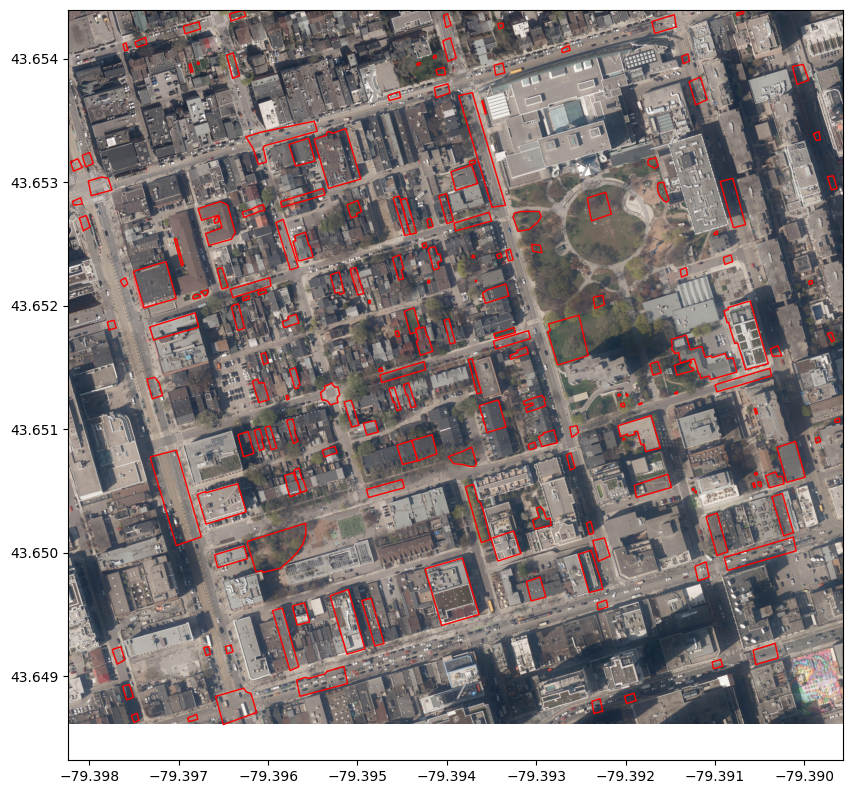

In [5]:
# Describe and show input data
fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(raster, ax=ax)
labelled_polygons.plot(ax=ax, edgecolor="red", facecolor="none", lw=1)

labelled_polygons.groupby('class').id.count()

## Prepare Training Data

In [9]:
X_list = []
y_list = []

# Process each class
for class_type in labelled_polygons['class'].unique():
    class_polygons = labelled_polygons[labelled_polygons['class'] == class_type]

    image, transform = mask(raster, class_polygons.geometry, crop=True)
    image = image.astype(np.float32) / 255.0  # Scale cropped image
    bands = image.reshape(3, -1).T
    
    X_list.append(bands)
    y_list.extend([class_type] * bands.shape[0])

X = np.vstack(X_list)
y = pd.Series(y_list)

### ***Optional:*** Visualize some training examples

In [ ]:
# Show a few training examples
for i in range(3):
    rasterio.plot.show(X_list[i]['image'], transform=X_train_full_list[i]['transform'])
    print(X_train_full_list[i]['class'])

### Feature Selection

In [ ]:
#features = ['image']
#X = X_train_full#[features]
#y = X_train_full['class']

### Split Training and Testing Data

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED)

In [23]:
print(X_train.shape, y_train.shape)

(23296256, 3) (23296256,)


### Fit Classifier


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=RNG_SEED)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate Accuracy

In [26]:
from sklearn.metrics import accuracy_score

y_pred_test = clf.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4427896053340073


In [27]:
# Beep when done
beep = np.sin(2*np.pi*800*np.arange(3000*2)/10000)
Audio(beep, rate=6000, autoplay=True)

## Predict the Image

In [28]:
# Set up the visualization colors and class values
class_colors = {'road': [0.7, 0.7, 0.7],    # Gray
                'building': [0.8, 0.2, 0.2], # Red
                'vegetation': [0.2, 0.8, 0.2]} # Green

# Convert class names to numerical values for plotting
class_values = {name: i for i, name in enumerate(class_colors.keys())}
colors = [class_colors[class_name] for class_name in class_colors.keys()]

In [29]:
#input_image = raster.read()
#rows, cols = input_image[0].shape

#input_image = input_image.reshape(3, -1).T
#predictions = clf.predict(input_image)

# Use scaled image for prediction
rows, cols = raster_shape[1], raster_shape[2]
input_image = scaled_image.reshape(3, -1).T
predictions = clf.predict(input_image)

numerical_predictions = np.array([class_values[pred] for pred in predictions])
pred_image = numerical_predictions.reshape((rows, cols))


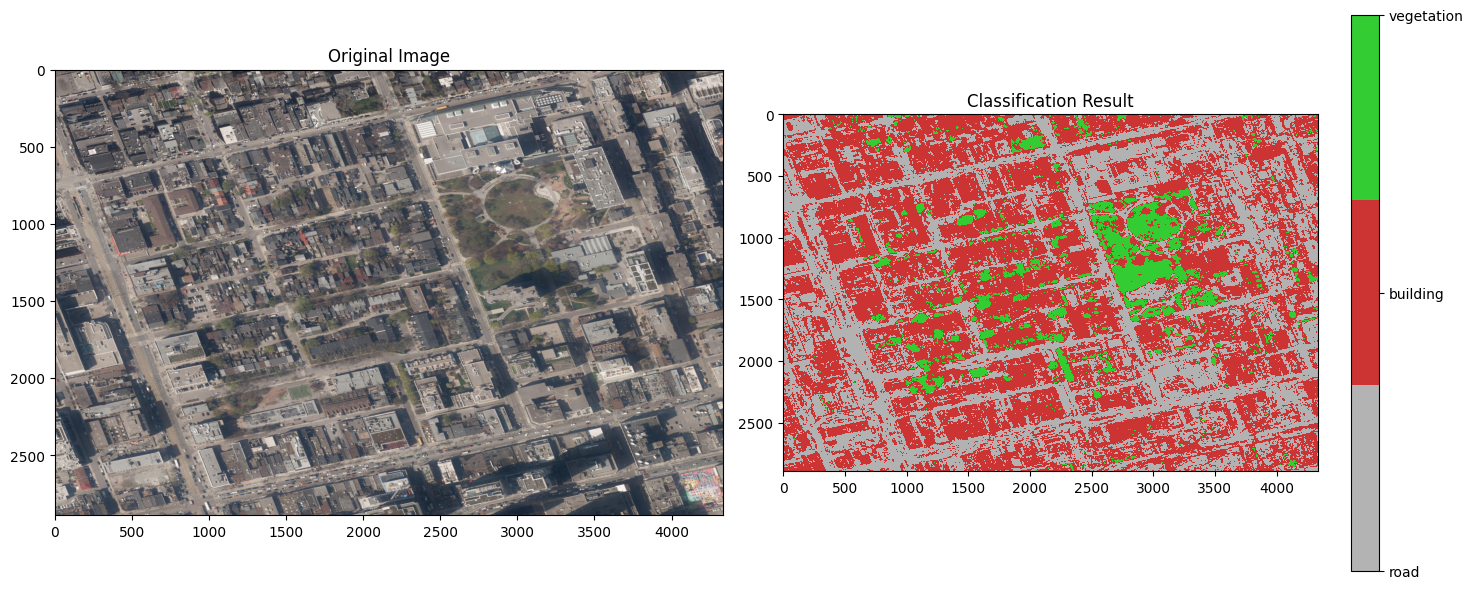

In [30]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot original image
rgb = scaled_image 
ax1.imshow(np.dstack((rgb[0], rgb[1], rgb[2])))
ax1.set_title('Original Image')

# Plot classification
im = ax2.imshow(pred_image, cmap=plt.cm.colors.ListedColormap(colors))
ax2.set_title('Classification Result')

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, ticks=range(len(class_values)))
cbar.ax.set_yticklabels(class_values.keys())

plt.tight_layout()
plt.show()

In [31]:
# Beep when done
beep = np.sin(2*np.pi*800*np.arange(3000*2)/10000)
Audio(beep, rate=6000, autoplay=True)